In [2]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [3]:
def system_dynamics(x_t, u_t):
    """
    System dynamics: x_t+1 = x_t + 0.5*u_t
    """
    return x_t + 0.5 * u_t

def analytical_controller(x_t):
    """
    Analytical control law to make x_t+1 = 0
    """
    return -2 * x_t

def reward_function(x_t, u_t):
    """
    Reward function: r_t = x_t + 0.5*u_t
    """
    return x_t**2 + 0.001 * (u_t**2)

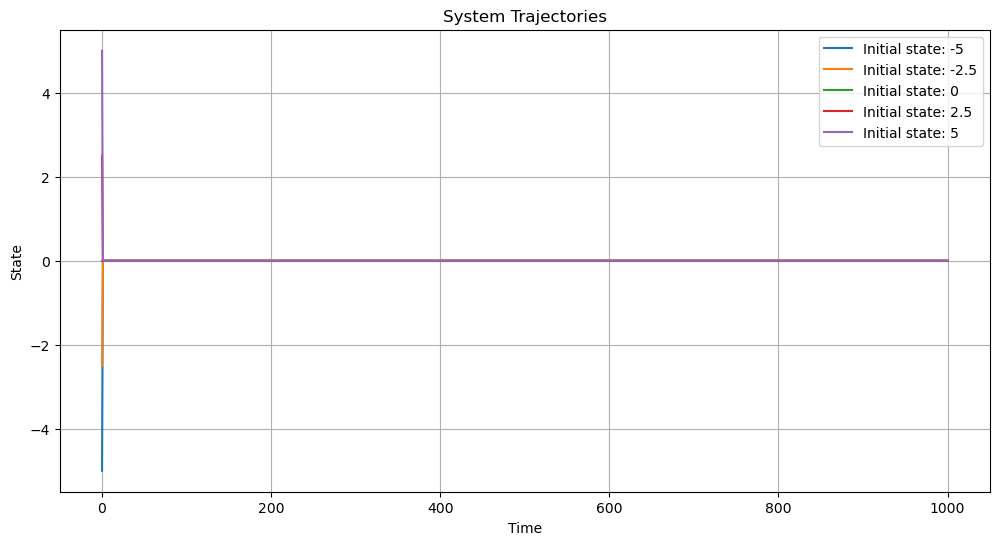

In [4]:
# Data
n_steps = 1000
x0_vals = [-5, -2.5, 0, 2.5, 5]
np.array(x0_vals)
np.random.seed(42)
time_steps = np.arange(n_steps + 1)

x_history = np.zeros((len(x0_vals), n_steps + 1))
u_history = np.zeros((len(x0_vals), n_steps))

for i, x0 in enumerate(x0_vals):
    x_history[i, 0] = x0
    for t in range(n_steps):
        u_t = analytical_controller(x_history[i, t])
        x_history[i, t + 1] = system_dynamics(x_history[i, t], u_t)
        u_history[i, t] = u_t

plt.figure(figsize=(12, 6))
for i in range(len(x0_vals)):
    plt.plot(time_steps, x_history[i], label=f'Initial state: {x0_vals[i]}')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('System Trajectories')
plt.grid()
plt.legend()
plt.show()

In [5]:
value_targets = np.zeros_like(x_history[:, :-1])  # shape = (5, 20)

for i in range(len(x0_vals)):
    total_cost = 0
    for j in reversed(range(n_steps)):
        cost = reward_function(x_history[i, j], u_history[i, j])
        total_cost += cost
        value_targets[i, j] = total_cost

# Flatten for NN training
X = x_history[:, :-1].flatten().reshape(-1, 1)  # shape = (5*20, 1)
Y = value_targets.flatten().reshape(-1, 1)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

inputs = Input(shape=(1,))
dense = Dense(64, activation='relu')(inputs)
dense = Dense(64, activation='relu')(dense)
outputs = Dense(1, activation='linear')(dense)

critic_model = Model(inputs=inputs, outputs=outputs)
critic_model.compile(optimizer='adam', loss='mse')

critic_model.fit(x_train, y_train, epochs=1000, batch_size=32)

Epoch 1/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step - loss: 0.2405
Epoch 2/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 0.1220  
Epoch 3/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 0.1667
Epoch 4/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.0929  
Epoch 5/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.0452
Epoch 6/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 0.0459  
Epoch 7/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 0.0087
Epoch 8/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.0177  
Epoch 9/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 0.0102  
Epoch 10/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 0.0309  
Epoch 11/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 0.0192
Epoch 12/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 0.0246   
Epoch 13/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.0185
Epoch 14/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step -

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


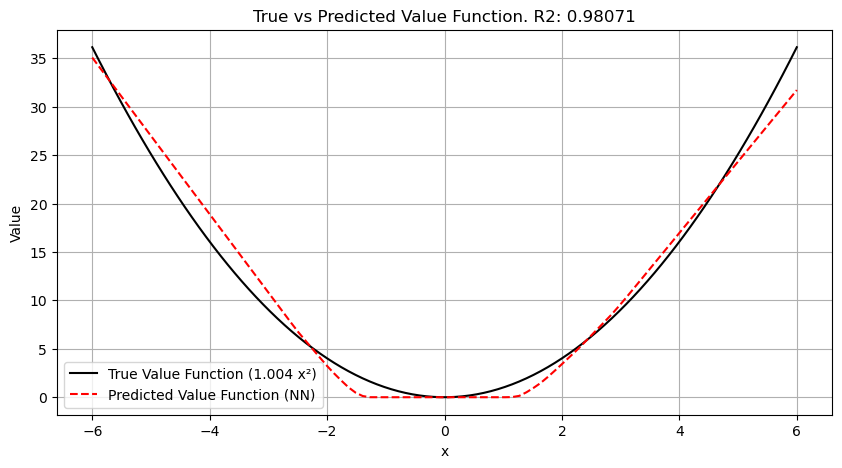

In [7]:
x_vals = np.linspace(-6, 6, 100).reshape(-1, 1)
v_pred = critic_model.predict(x_vals)
v_true = 1.004 * (x_vals ** 2)
r2 = r2_score(v_true, v_pred)

plt.figure(figsize=(10, 5))
plt.plot(x_vals, v_true, label='True Value Function (1.004 x²)', color='black')
plt.plot(x_vals, v_pred, label='Predicted Value Function (NN)', linestyle='--', color='red')
plt.xlabel('x')
plt.ylabel('Value')
plt.title(f'True vs Predicted Value Function. R2: {r2:.5f}')
plt.grid()
plt.legend()
plt.show()

In [8]:
q_targets = np.zeros_like(u_history)  # (5, 20)

for i in range(len(x0_vals)):
    total_cost = 0
    for t in reversed(range(n_steps)):
        cost = reward_function(x_history[i, t], u_history[i, t])
        total_cost += cost
        q_targets[i, t] = total_cost

X_q = np.hstack([
    x_history[:, :-1].reshape(-1, 1),  # x_t
    u_history.reshape(-1, 1)          # u_t
])
Y_q = q_targets.reshape(-1, 1)         # Q(x_t, u_t)

In [9]:
xq_train, xq_test, yq_train, yq_test = train_test_split(X_q, Y_q, test_size=0.2, random_state=42)

inputs = Input(shape=(2,))  # two inputs: x_t and u_t
dense = Dense(64, activation='relu')(inputs)
dense = Dense(64, activation='relu')(dense)
outputs = Dense(1, activation='linear')(dense)

q_model = Model(inputs, outputs)
q_model.compile(optimizer='adam', loss='mse')
q_model.fit(xq_train, yq_train, epochs=500, batch_size=32)

Epoch 1/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step - loss: 0.2883    
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.3681
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 0.0100    
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.0810
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 0.0574
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.0188  
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 0.0240  
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.0086
Epoch 9/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.0223
Epoch 10/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.0410  
Epoch 11/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.0077 
Epoch 12/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.0209  
Epoch 13/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.0082  
Epoch 14/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 0.0

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


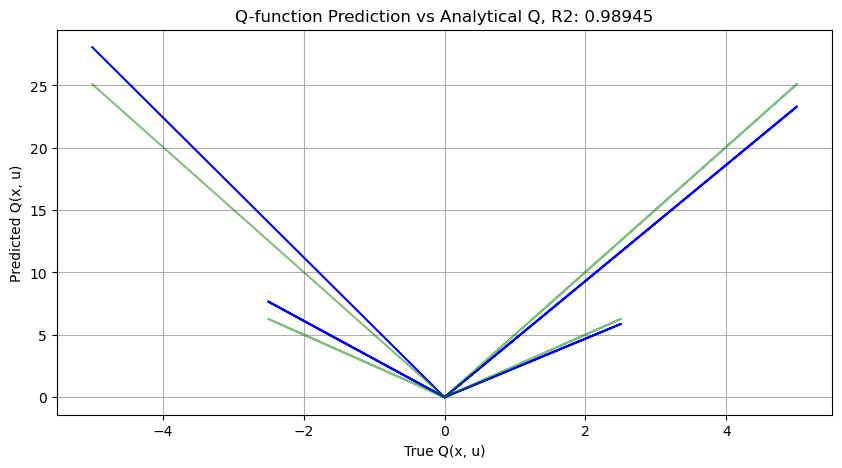

In [10]:
# Predict using the trained model
y_pred_q = q_model.predict(X_q)

# Compute true Q values from formula
x_vals_flat = X_q[:, 0]
u_vals_flat = X_q[:, 1]
q_true = 2.004 * x_vals_flat**2 + 1.004 * x_vals_flat * u_vals_flat + 0.252 * u_vals_flat**2
q_true = q_true.reshape(-1, 1)
r2 = r2_score(q_true, y_pred_q)

# Plot predicted vs true
plt.figure(figsize=(10, 5))
# plt.scatter(q_true, y_pred_q, alpha=0.5)
plt.plot(x_vals_flat, y_pred_q, label='Predicted Q(x, u)', color='blue')
plt.plot(x_vals_flat, q_true, label='True Q(x, u)', color='green', alpha=0.5)
plt.xlabel("True Q(x, u)")
plt.ylabel("Predicted Q(x, u)")
plt.title(f"Q-function Prediction vs Analytical Q, R2: {r2:.5f}")
plt.grid()
# plt.plot([q_true.min(), q_true.max()], [q_true.min(), q_true.max()], 'r--')
plt.show()

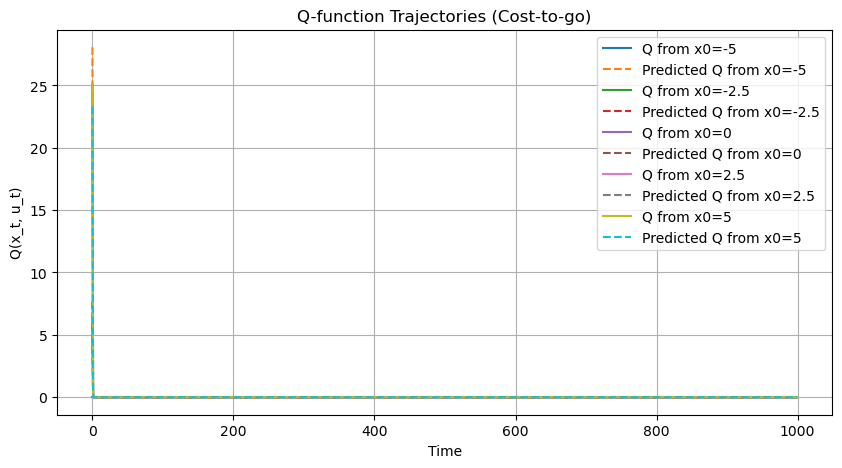

In [11]:
plt.figure(figsize=(10, 5))
for i in range(len(x0_vals)):
    plt.plot(range(n_steps), q_targets[i], label=f'Q from x0={x0_vals[i]}')
    plt.plot(range(n_steps), y_pred_q[i * n_steps:(i + 1) * n_steps], linestyle='--', label=f'Predicted Q from x0={x0_vals[i]}')
plt.xlabel("Time")
plt.ylabel("Q(x_t, u_t)")
plt.title("Q-function Trajectories (Cost-to-go)")
plt.legend()
plt.grid(True)
plt.show()
